In [48]:
import json
import pandas as pd
import networkx as nx
import geopy.distance
import matplotlib.pyplot as plt

In [49]:
class SNCFNetworkRouter:
    def __init__(self, stations_file, network_file):
        self.stations_df = pd.read_json(stations_file)
        with open(network_file, 'r', encoding='utf-8') as f:
            self.network_data = json.load(f)
        
        self.graph = nx.Graph()
        self._build_network()
    
    def _build_network(self):
        for _, station in self.stations_df.iterrows():
            self.graph.add_node(
                station['LIBELLE'], 
                pos=(station['X_WGS84'], station['Y_WGS84'])
            )
        
        stations = self.stations_df.to_dict('records')
        for i, station1 in enumerate(stations):
            for station2 in stations[i+1:]:
                distance = geopy.distance.distance(
                    (station1['Y_WGS84'], station1['X_WGS84']),
                    (station2['Y_WGS84'], station2['X_WGS84'])
                ).kilometers
                
                if distance < 100:
                    self.graph.add_edge(
                        station1['LIBELLE'], 
                        station2['LIBELLE'], 
                        weight=distance
                    )
    
    def find_route(self, start_city, end_city):
        try:
            # route = nx.shortest_path(self.graph, start_city, end_city, weight='weight')
            route = nx.dijkstra_path(self.graph, start_city, end_city)

            total_distance = sum(
                geopy.distance.distance(
                    (self.stations_df[self.stations_df['LIBELLE'] == route[i]]['Y_WGS84'].values[0],
                     self.stations_df[self.stations_df['LIBELLE'] == route[i]]['X_WGS84'].values[0]),
                    (self.stations_df[self.stations_df['LIBELLE'] == route[i+1]]['Y_WGS84'].values[0],
                     self.stations_df[self.stations_df['LIBELLE'] == route[i+1]]['X_WGS84'].values[0])
                ).kilometers 
                for i in range(len(route)-1)
            )
            
            return route, total_distance
        except nx.NetworkXNoPath:
            return None, None
        
    def visualize_route(self, route):
        plt.figure(figsize=(15, 10))
        pos = {station: (self.stations_df[self.stations_df['LIBELLE'] == station]['X_WGS84'].values[0],
                         self.stations_df[self.stations_df['LIBELLE'] == station]['Y_WGS84'].values[0])
               for station in self.graph.nodes()}
        
        # Dessiner tous les nœuds
        nx.draw_networkx_nodes(self.graph, pos, node_color='lightgray', node_size=20)
        
        # Mettre en évidence la route
        route_edges = list(zip(route, route[1:]))
        nx.draw_networkx_nodes(self.graph, pos, nodelist=route, node_color='red', node_size=50)
        nx.draw_networkx_edges(self.graph, pos, edgelist=route_edges, edge_color='r', width=2)
        
        # Ajouter les labels des gares de la route
        labels = {node: node for node in route}
        nx.draw_networkx_labels(self.graph, pos, labels, font_size=8)
        
        plt.title('Itinéraire Ferroviaire')
        plt.axis('off')
        plt.tight_layout()
        plt.show()


In [50]:
router = SNCFNetworkRouter('assets/data.json', 'assets/liste-des-circuits-de-voie.json')

In [52]:
route, distance = router.find_route('Strasbourg-Ville', 'Paris-Gare-de-Lyon')

In [53]:
print("Itinéraire:")
for i, station in enumerate(route):
    print(f"{i+1}. {station}")
print(f"\nNombre d'étapes : {len(route)}")

Itinéraire:
1. Strasbourg-Ville
2. Cernay
3. Paris-Gare-de-Lyon

Nombre d'étapes : 3


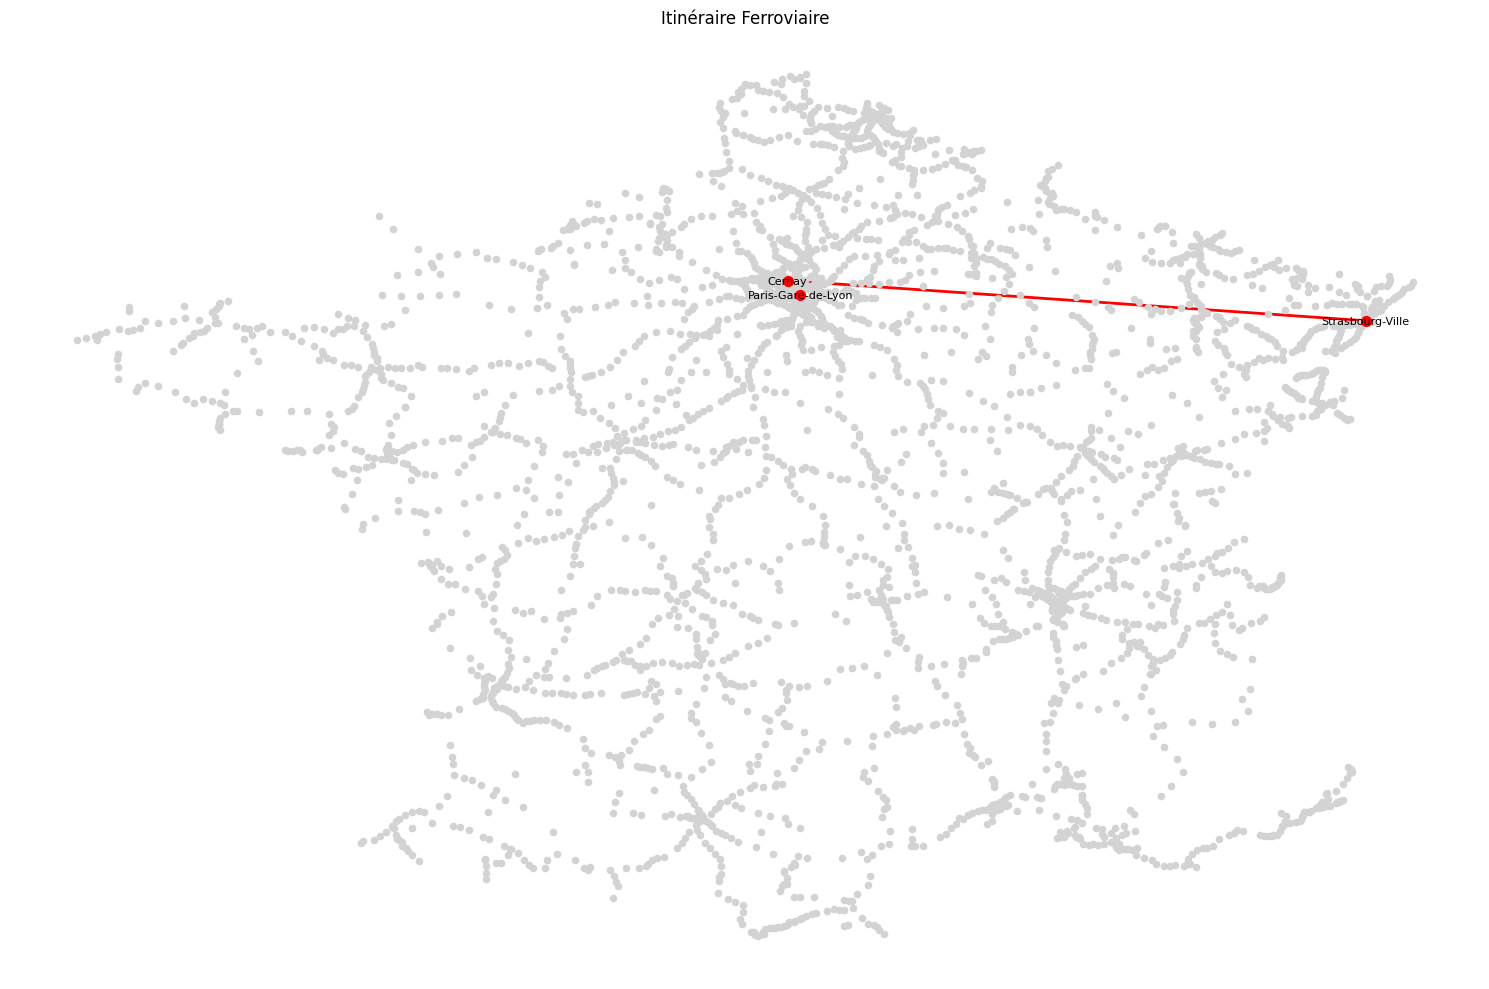

In [54]:
router.visualize_route(route)